# Few Shot learning: Classify using few examples!

Deepam Minda  
2023-09-12

## Introduction

If you aren’t already familiar with it, few-shot learning (FSL) is an
exciting concept in machine learning that focuses on training models to
make accurate predictions or classifications when provided with only a
very limited amount of labeled data for each category or class. Unlike
traditional machine learning approaches that often require substantial
labeled datasets for training, few-shot learning aims to address
scenarios where acquiring such extensive labeled data is impractical or
costly.

In few-shot learning, the model is trained to generalize effectively
from a small number of examples (or shots) per category, allowing it to
make predictions for new, unseen data points with confidence. This
capability is particularly valuable in situations where data is scarce,
and manual annotation is labor-intensive or expensive. Refer to \[1\]
for an in-depth survey in this field.

In this blog, I’m going to show you how to implement a basic few-shot
classification technique for text.

## Terminology

Before we begin, let us familiarize ourselves with the correct
terminology.

What characterizes FSL is having only a few examples at hand, for unseen
classes, during inference. So basically we are showing the model only a
few examples of a class which it may or may not have encountered during
its pre-training before we make predictions using that model.

**Support Set, 𝒮:** The few annotated examples that we have, make up the
support set, with which we may or may not update the model weights to
make it generalize to the new classes.

**Query Set, 𝒬:** The query set consists of our test set, i.e. the
samples we want to classify using the base model and a support set.

**N-way K-shot learning scheme:** This is a common phrase used in the
FSL literature, which essentially describes the few-shot problem
statement that a model will be dealing with. “N” is the number of
classes we have at test time and “K” is the number of samples per class
we have in our support set “𝒮”

**1-shot classification:** When K=1, i.e. we have only one labeled
sample available per class.

**0-shot classification:** K=0, i.e. we do not have any labeled samples
available during inference.

Let us have a look at an example.

In [46]:
# sample set is 3-way, 3-shot.
classes = ['camera', 'battery', 'display']

sample_set = {
    'camera': [
        'absolutely love this quality of my photos!!',
        'it even gives great quality in dim lighting. fabulous!!',
        'the camera should be much better for such a high price'
    ],
    'battery': [
        "The battery life on this device is exceptional! It easily lasts me the entire day with heavy usage.",
        "I'm a bit disappointed with the battery performance. It drains quite quickly, especially when using power-hungry apps.",
        "The battery is decent, not too bad, not too good. It gets me through the day, but I was hoping for better longevity."
    ],
    'display': [
        "The display on this device is stunning! Colors are vivid, and the resolution is top-notch.",
        "I'm not too impressed with the display quality. It seems a bit washed out, and the brightness could be better.",
        "The display is okay, but nothing extraordinary. It gets the job done for everyday tasks."
    ]
}

query_set = ["i hate the batteries", "does it give good quality photos in the night?"]

Here we have a 3-way (there are 3 classes), 3-shot (3 examples for each
class) setting.

## High level design

Let us have a quick look at the architecture of the system.

<figure id="few-shot">
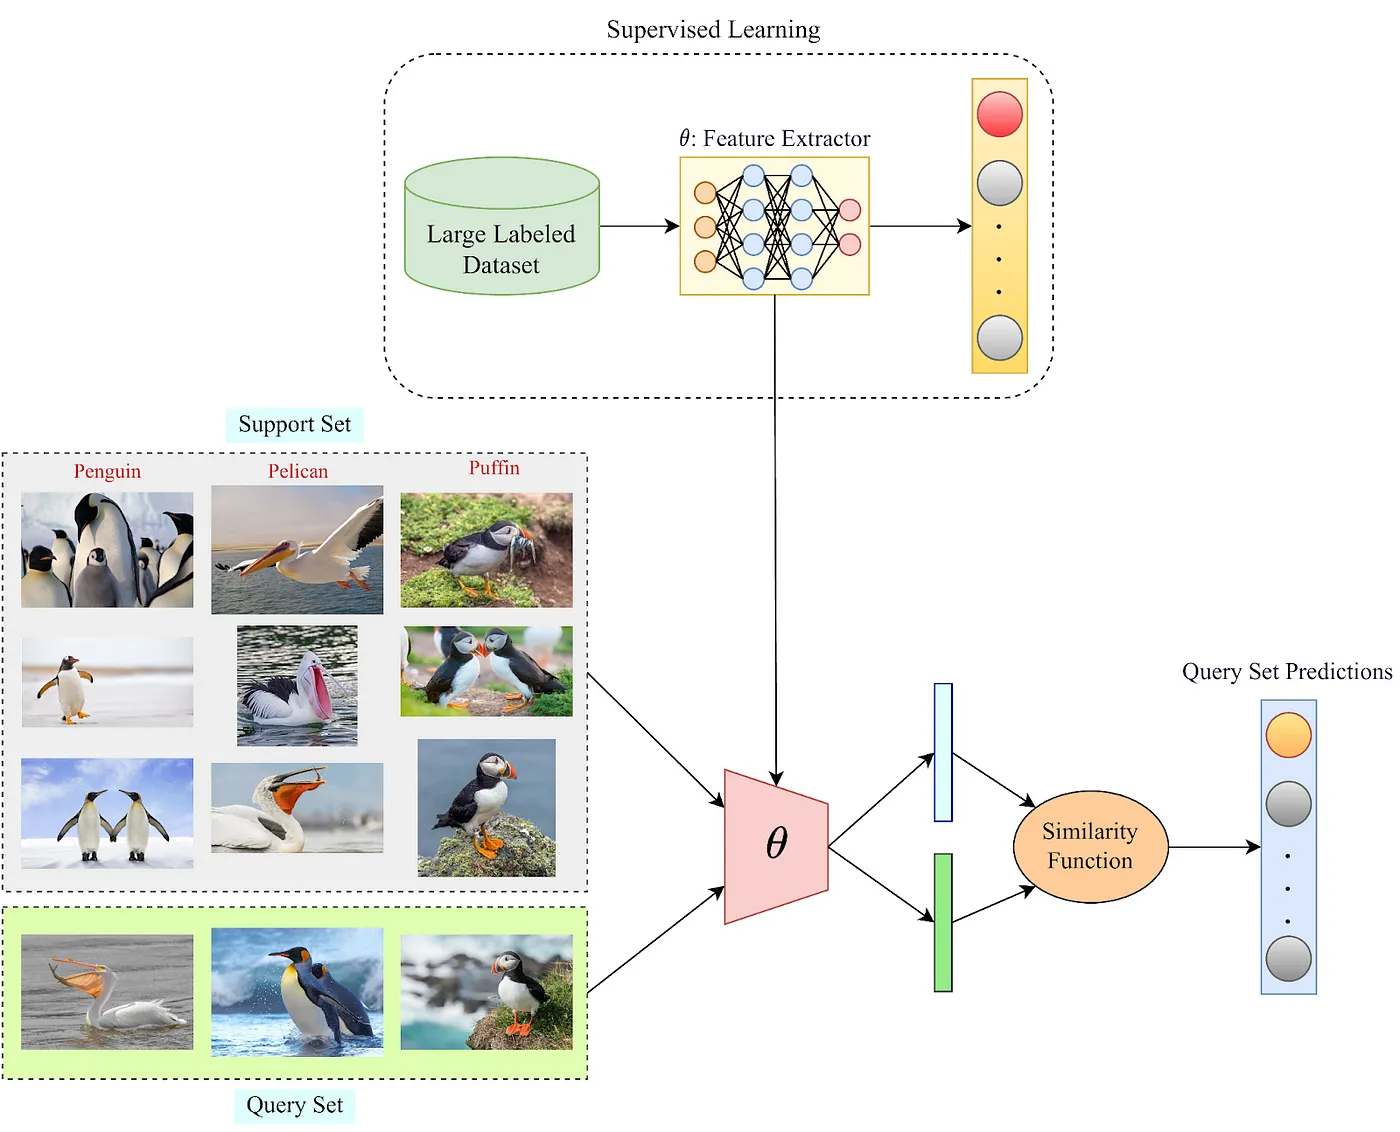
<figcaption aria-hidden="true">A simple few shot classification
system</figcaption>
</figure>

This is the flow of our solution:

The first step is to get an embedding module. That can be created using
regular supervised learning (Resnets trained on Imagenet) or
self-supervised learning (BERT and co). Then, we use the embedding
module to get feature representations for our classes in the support
set. A simple way to do this is to turn each class’s examples into
embeddings and take the mean of those vectors. This then becomes our
“prototype” vectors to compare against. Now for each query, we can take
the embeddings of the query text and use cosine similarity to find the
predicted class. This closely resembles This system basically allows us
to leverage transfer learning to use large backbones as our embedding
module. And there is also the advantage of not performing any gradient
updates. This helps us maintain a much more dynamic and flexible system.

The idea of comparing query samples with the support set samples is
inspired by metric learning. Refer to \[3, 4\] for better understanding.

Let’s implement this using the transformers library. You can find the
implementation in this colab notebook.

## Implementation

Let’s start with the good old BERT base model.

### 1. Import libraries and download model

In [47]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from typing import Dict
from pprint import pprint
import warnings 
warnings.filterwarnings("ignore")

if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
# load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained("bert-base-uncased")

### 2. Tokenize and encode a sentence

In [71]:
text = "He's such a great guy!!"
encoded_input = tokenizer(
  text, 
  return_tensors='pt', 
  padding='max_length',     # True will pad to max-len in batch
  max_length=32
)
print(f"encoded input:")
pprint(encoded_input)

encoded input:
{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[ 101, 2002, 1005, 1055, 2107, 1037, 2307, 3124,  999,  999,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

where,

-   input_ids: token id of each token
-   token_type_id: When we pass two sentences for downstream fine-tuning
    in BERT, this is used to identify which token belongs to which
    sentence.
-   attention_mask: which tokens to ignore. As you’ll see, the padding
    tokens have been masked.

### 3. Generate embeddings using model

The output has 2 parts, `cls_token_embeddings` and `last_hidden_states`
of the tokens. We can either use the cls_embeddings to represent the
sentence or pool the vectors in last_hidden_states. The pooling can be
max/min/mean.

The dimension of the output will be equal to the embedding dimension of
the model, i.e. 784 in our case.

In [60]:
def get_embeddings(model, tokenizer, text, pooling='mean'):
  
  encoded_input = tokenizer(
    text, 
    return_tensors='pt', 
    padding='max_length', 
    max_length=16, 
    truncation=True
  )
  encoded_input = encoded_input.to(device)

  model.to(device)

  model.eval()
  with torch.no_grad():
    output = model(**encoded_input)
    last_hidden_state, pooler_output = output[0], output[1]
    
    if pooling=='cls':
      embedding = pooler_output
    else:
      # ignore the pad tokens embeddings by multiplying with attention mask
      last_hidden_state = (last_hidden_state * encoded_input['attention_mask'].unsqueeze(2))
      embedding = last_hidden_state.mean(dim=-2)
  return np.array(embedding.cpu())


embeddings = get_embeddings(model, tokenizer, 'hey there! how are you?')
print(f"shape of embeddings: {embeddings.shape}")

shape of embeddings: (1, 768)

### 4. Prepare the prototypes:

To prepare the class prototypes we’ll take the mean of the sentences for
each class.

In [61]:
def make_prototypes(model, tokenizer, sample_set: Dict):
  prototype_vectors = dict()
  sentence_embeddings = dict()
  for category, sentences in sample_set.items():
    sentence_embeds = get_embeddings(model, tokenizer, sentences)
    sentence_embeddings[category] = sentence_embeds
    prototype_vectors[category] = np.mean(sentence_embeddings[category], axis=0)
  return prototype_vectors


### 5. Classify

To classify a query text, we can run cosine similarity against the
prototype vectors and return the argmax as the most probable class!

In [62]:
def classify(model, tokenizer, text, prototype_vectors=None, sample_set=None):
  if prototype_vectors==None:
      assert sample_set!=None, "prototype vectors are not passed, either pass a sample set prototype vectors"
      prototype_vectors = make_prototypes(sample_set)

  query_embeddings = get_embeddings(model, tokenizer, text)
  
  prototype_matrix = np.stack(list(prototype_vectors.values()))
  scores = sentence_transformers.util.cos_sim(query_embeddings, prototype_matrix)
  return scores

Using the above-defined functions and the sample set from before, we
have:

In [65]:
prototype_vectors = make_prototypes(model, tokenizer, sample_set)
query_text = "i hate the batteries"
output = classify(model, tokenizer, query_text, prototype_vectors=prototype_vectors)

print(f"output: {output}")
print(f"the predicted class is {classes[output.argmax().item()]}")

output: tensor([[0.6121, 0.7127, 0.6388]])
the predicted class is battery

A bit strange! Although the expected class is predicted, scores for
other classes are also high. Let’s try a harder query.

In [66]:
query = ['does it give good quality photos in the night?']
output = classify(model, tokenizer, query, prototype_vectors=prototype_vectors)

print(f"output: {output}")
print(f"the predicted class is {classes[output.argmax().item()]}")

output: tensor([[0.7984, 0.7043, 0.7647]])
the predicted class is camera

Although the highest similarity is for ‘camera’, the similarity should
be much higher.

The results do not get better even if we try cls-pooling. This only
means that the embeddings produced by the model do not give us an
accurate representation of the sentence.

We would then do good to remember that BERT pre-train was trained by
MaskedLM, NextSentencePrediction, hence the original purpose of BERT is
not to create a meaningful embedding of the sentence but for some
specific downstream task. In fact, as the authors of the
sentence-transformer paper \[2\] point out, out-of-the-box Bert
embeddings perform even worse than GLoVE representations!

> Jacob Devlin’s comment: I’m not sure what these vectors are, since
> BERT does not generate meaningful sentence vectors. It seems that this
> is is doing average pooling over the word tokens to get a sentence
> vector, but we never suggested that this will generate meaningful
> sentence representations. And even if they are decent representations
> when fed into a DNN trained for a downstream task, it doesn’t mean
> that they will be meaningful in terms of cosine distance. (Since
> cosine distance is a linear space where all dimensions are weighted
> equally).

There are a few ways to improve the bert-base for sentence-level tasks
and both involve finetuning the model with some data.

-   adding a linear layer on top and fine-tuning it.
-   making embeddings better by contrastive learning.

## Using sentence transformers

Ultimately, what we need is a better embedding module. Luckily we have
such models. As it turns out, contrastive learning is an excellent
approach for tuning our models such that different sentences produce
semantically different embeddings.

We will explore contrastive learning and its inner workings some other
day, but for now, let’s pick up open-source models that have been
finetuned using contrastive learning. There is an entire library (aka
sentence-transformers) and paper\[2\] dedicated to this.

We’ll use the `sentence-transformers/stsb-bert-base` model for our
purposes.

### 1. Import packages and download model

In [55]:
from sentence_transformers import SentenceTransformer

# load a sentence transformer model
sts_model = SentenceTransformer('sentence-transformers/stsb-bert-base')
model2 = sts_model[0].auto_model.to(device)
tokenizer2 = sts_model[0].tokenizer

### 2. Use the above-defined functions to prepare prototype vectors and classify them in a few-shot setting

In [67]:
prototype_vectors = make_prototypes(model2, tokenizer2, sample_set)
query_text = "i hate the batteries"
output = classify(model2, tokenizer2, query_text, prototype_vectors)

print(f"output: {output}")
print(f"the predicted class is {classes[output.argmax().item()]}")

output: tensor([[0.0910, 0.4780, 0.1606]])
the predicted class is battery

In [68]:

query = ['does it give good quality photos in the night?']
output = classify(model2, tokenizer2, query, prototype_vectors=prototype_vectors)

print(f"output: {output}")
print(f"the predicted class is {classes[output.argmax().item()]}")

output: tensor([[0.4467, 0.1012, 0.2998]])
the predicted class is camera

As we can see, the scores seem much more reasonable this time around.
There is a much better correlation with the ground truth labels. Using
better base models trained in multiple tasks further improves the
performance of these models.

## Conclusion

This brings us to the end of this blog. In summary, we explored the
realm of few-shot learning, a machine-learning approach tailored for
accurate predictions with limited labeled data. Initially, we employed
BERT, but its design didn’t align with our objectives. Instead, we
leveraged a model fine-tuned for sentence-level tasks,
`sentence-transformers/stsb-bert-base`, which significantly improved our
results.

**These are a few things to note:**

Although we directly used pre-trained models here, an interesting
undertaking would be to perform the contrastive fine-tuning ourselves.
Also, instead of using cosine similarity, we can train lightweight
classifiers on top of our embedding module for better performance.

That’ll be all from my side. Until next time, Happy Reading!

## References

\[1\] [Survey paper on few-shot
learning](https://arxiv.org/pdf/1904.05046.pdf)

\[2\] [Sentence-Bert paper](https://arxiv.org/pdf/1908.10084.pdf)

\[3\] [Prototypical
Networks](https://proceedings.neurips.cc/paper_files/paper/2017/file/cb8da6767461f2812ae4290eac7cbc42-Paper.pdf)

\[4\] [Excellent much more techincal blog by Lilian
Weng](https://lilianweng.github.io/posts/2018-11-30-meta-learning/#metric-based)